<a href="https://colab.research.google.com/github/RJuro/GA2019/blob/master/GA2019_Intro_to_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#surpresses lots of output
%%capture 
!pip install whatthelang
!pip install umap-learn
!pip install eli5

# Introduction to Natural Language Processing & Machine Learning for Social Science Research

## Globelics Academy 2019 - Computational Methods Part3
### Roman Jurowetzki - 14/8 - 2019; roman@business.aau.dk

- In this tutorial we will explore some relatively approachible techniques to utilize text as valuable data source in social science research. 
- The tutorial will use Python and several modern NLP and Machine Learning libraries to appraoch the problems
- I will present 3 cases of typical applications that can be transferred to different reserach contexts.

## Case 1: AirBnb in Mexico City

AirBnb is collecting large amounts of text data every time the platform asks hosts and guests to review each other. This information is essential to create trust and to allow transactions on the platform. 

The textual data is valuable as it countatins lots of information. We can for example ask:

- why did some one like or dislike a place?
- do people describe cheaper stays differently than those that are expensive?

We will use data form [InsideAirbnb](http://insideairbnb.com/ "Airbnb"), an independant platform that tracks Airbnb's influence on urban communities 

We will be using some out-of-the-box modules rather than train our classifiers from the ground up.

In [0]:
# import the pandas library for handling CSVs and table-type data 
# import numpy for some (simple) linear algebra
import pandas as pd
import numpy as np

In [4]:
# download and unzip the data that we are going to use
!wget https://storage.googleapis.com/roman-general/data.zip

--2019-08-12 09:59:34--  https://storage.googleapis.com/roman-general/data.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 2607:f8b0:400e:c08::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 61163094 (58M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  58.33M  42.5MB/s    in 1.4s    

2019-08-12 09:59:36 (42.5 MB/s) - ‘data.zip’ saved [61163094/61163094]



In [5]:
!unzip data.zip

Archive:  data.zip
   creating: data/
  inflating: data/upwork_aom_300k.csv  
   creating: __MACOSX/
   creating: __MACOSX/data/
  inflating: __MACOSX/data/._upwork_aom_300k.csv  
  inflating: data/reviews.csv        
  inflating: __MACOSX/data/._reviews.csv  
  inflating: data/spanish_revs.csv   
  inflating: __MACOSX/data/._spanish_revs.csv  
  inflating: data/listings.csv       
  inflating: __MACOSX/data/._listings.csv  


In [6]:
cd data

/content/data


In [0]:
reviews = pd.read_csv('reviews.csv')

In [0]:
from whatthelang import WhatTheLang

In [0]:
wtl = WhatTheLang()

In [0]:
def detect_lang(text):
    try: 
        return wtl.predict_lang(text)
    except Exception:
        return 'exp'

In [16]:
%time reviews['lang'] = reviews['comments'].map(lambda t: detect_lang(t))

CPU times: user 22.8 s, sys: 37.1 ms, total: 22.9 s
Wall time: 22.9 s


In [0]:
# Open the reviews and reduce from 300k to random 10k rows

reviews = pd.read_csv('reviews.csv')
reviews = reviews.sample(50000)

In [6]:
reviews.head()

,listing_id,id,date,reviewer_id,reviewer_name,comments
39554,5082965,112034833,2016-11-03,12433621,Taylor,Martha was a wonderful host! She was very acco...
104278,11825682,121697959,2016-12-18,46306359,Rene,"Carlos was very pollite,cool and informative...."
24119,2807016,92772761,2016-08-10,23397246,Gabrielle,We had a very positive experience at Lorena's ...
230801,20154527,231107818,2018-01-30,165147949,Ariel,El servicio cumplió nuestras expectativas. La ...
266863,22230741,431804865,2019-04-01,237673796,Ella,"Oskar is very helpful, interested and generous..."


#### Language detection
First we need to detect the language of the review, as we will only focus on the English reviews

The `langid` library is a good choice. It's easy to use and fast

In [0]:
# import the library

import langid

Text data is messy: Sometimes people just add 😉 or somewhint completely different. This is where the model gets into trouble and returns errors.
To prevent that form happening, we will write a little function that turns exceptions into "exp"


In [0]:
#defining a little exception-handling function for the language detector

def detect_lang(text):
    try: 
        return langid.classify(text)[0]
    except Exception:
        return 'exp'

In [0]:
# we apply the language detection function
reviews['lang'] = reviews['comments'].apply(detect_lang)

In [0]:
# now, we filter out the spanish reviews
english_reviews = reviews[reviews['lang'] == 'en']
english_reviews = english_reviews.sample(n=25000)

#### Sentiment analysis - easy version
In this part of the tutorial we will be using a pre-trained Spanish sentiment analysis model from https://github.com/aylliote/senti-py to figure out how people feel about their stays

In [18]:
# We import and instantiate the classifier
  >>> import nltk
  >>> nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


/usr/local/lib/python3.6/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [0]:
# Let's try it out
sentences = ["VADER is smart, handsome, and funny.", # positive sentence example
...    "VADER is smart, handsome, and funny!", # punctuation emphasis handled correctly (sentiment intensity adjusted)
...    "VADER is very smart, handsome, and funny.",  # booster words handled correctly (sentiment intensity adjusted)
...    "VADER is VERY SMART, handsome, and FUNNY.",  # emphasis for ALLCAPS handled
...    "VADER is VERY SMART, handsome, and FUNNY!!!",# combination of signals - VADER appropriately adjusts intensity
...    "VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!",# booster words & punctuation make this close to ceiling for score
...    "The book was good.",         # positive sentence
...    "The book was kind of good.", # qualified positive sentence is handled correctly (intensity adjusted)
...    "The plot was good, but the characters are uncompelling and the dialog is not great.", # mixed negation sentence
...    "A really bad, horrible book.",       # negative sentence with booster words
...    "At least it isn't a horrible book.", # negated negative sentence with contraction
...    ":) and :D",     # emoticons handled
...    "",              # an empty string is correctly handled
...    "Today sux",     #  negative slang handled
...    "Today sux!",    #  negative slang with punctuation emphasis handled
...    "Today SUX!",    #  negative slang with capitalization emphasis
...    "Today kinda sux! But I'll get by, lol" # mixed sentiment example with slang and constrastive conjunction "but"
... ]

In [0]:
sid = SentimentIntensityAnalyzer()

In [21]:
for sentence in sentences:
  print(sentence)
  ss = sid.polarity_scores(sentence)
  print(ss)

VADER is smart, handsome, and funny.
{'neg': 0.0, 'neu': 0.254, 'pos': 0.746, 'compound': 0.8316}
VADER is smart, handsome, and funny!
{'neg': 0.0, 'neu': 0.248, 'pos': 0.752, 'compound': 0.8439}
VADER is very smart, handsome, and funny.
{'neg': 0.0, 'neu': 0.299, 'pos': 0.701, 'compound': 0.8545}
VADER is VERY SMART, handsome, and FUNNY.
{'neg': 0.0, 'neu': 0.246, 'pos': 0.754, 'compound': 0.9227}
VADER is VERY SMART, handsome, and FUNNY!!!
{'neg': 0.0, 'neu': 0.233, 'pos': 0.767, 'compound': 0.9342}
VADER is VERY SMART, really handsome, and INCREDIBLY FUNNY!!!
{'neg': 0.0, 'neu': 0.294, 'pos': 0.706, 'compound': 0.9469}
The book was good.
{'neg': 0.0, 'neu': 0.508, 'pos': 0.492, 'compound': 0.4404}
The book was kind of good.
{'neg': 0.0, 'neu': 0.657, 'pos': 0.343, 'compound': 0.3832}
The plot was good, but the characters are uncompelling and the dialog is not great.
{'neg': 0.327, 'neu': 0.579, 'pos': 0.094, 'compound': -0.7042}
A really bad, horrible book.
{'neg': 0.791, 'neu': 0.2

**speed issues**

Preprocessing of the text and prediction takes some time, unfortunately. These are, after all, heavy processes.  We will use simple multiprocessing (using all cores of the CPU) to optimize performance 

In [0]:
# Engage multiprocessing

from multiprocessing import Pool
p = Pool()

In [30]:
%%time
# Calculate the scores (sentiment analysis) that will take around 4 Minutes

english_reviews['score'] = p.map(sid.polarity_scores, english_reviews['comments'])
english_reviews['score'] = english_reviews['score'].map(lambda x: x['compound'])

CPU times: user 138 ms, sys: 63.9 ms, total: 202 ms
Wall time: 15.6 s


In [31]:
# Let's print the reviews starting with the top 20 negative ones

for i in english_reviews.sort_values('score', ascending=True)['comments'][:20]:
    print(i)
    print('\n')

I will leave the perfect description regarding this place: 
1. we were excited there was a doorman because that meant to us that the building was going to be nice, but the building had a smell, sofas in the ‘lobby’ are worn out, ugly in general. 
2. the apartment has a nice view but using the balcony is unpleasant since there is nothing there, except an old table and chairs.  
3. the apartment has a smell. in general the apartment’s walls, windows, and kitchen are old 
4. we had NO hot water during our stay. contacted the host but nothing was solved. had to shower with cold water at 5:00am the day we were leaving to the airport.  
5. there is no AC, and we knew that before confirming our stay, but the apartment is HOT. there is 1 standing fan in the bedroom. 
6. you won’t want to sit in the chairs and the sofas since they are stained, worn out, and look dirty. 
7. good location
8. in order to leave you have to leave the key in the apartment, but need the key to get out of the building 

#### Bringing in additional data for analysis
Now we can use additional information that we have on the houses to actually use our predictions

In [0]:
# we open the listings data
listings = pd.read_csv('listings.csv')

In [0]:
# We can calculate the median scores for all rooms
scores = pd.DataFrame(english_reviews.groupby('listing_id').median()['score'])

In [0]:
# We merge the listing data with our median reviews
merged = pd.merge(listings, scores, how='inner', left_on='id', right_on='listing_id')

In [35]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6284 entries, 0 to 6283
Data columns (total 17 columns):
id                                6284 non-null int64
name                              6282 non-null object
host_id                           6284 non-null int64
host_name                         6284 non-null object
neighbourhood_group               0 non-null float64
neighbourhood                     6284 non-null object
latitude                          6284 non-null float64
longitude                         6284 non-null float64
room_type                         6284 non-null object
price                             6284 non-null int64
minimum_nights                    6284 non-null int64
number_of_reviews                 6284 non-null int64
last_review                       6284 non-null object
reviews_per_month                 6284 non-null float64
calculated_host_listings_count    6284 non-null int64
availability_365                  6284 non-null int64
score              

In [36]:
# Now we can for example explore median scores for the different parts of town

merged.groupby('neighbourhood').median()['score'].sort_values()

neighbourhood
Cuajimalpa de Morelos     0.796300
La Magdalena Contreras    0.815225
Tlalpan                   0.852500
Venustiano Carranza       0.878475
Iztacalco                 0.880800
Álvaro Obregón            0.890300
Azcapotzalco              0.895600
Gustavo A. Madero         0.897900
Iztapalapa                0.903800
Benito Juárez             0.903950
Miguel Hidalgo            0.905000
Xochimilco                0.930000
Cuauhtémoc                0.931000
Coyoacán                  0.931775
Tláhuac                   0.966800
Name: score, dtype: float64

## Case 2: Explaining text-predictions

Machine learning models are often considered "black-boxes". Especially more complex models (e.g. XGboost, SVMs, Neural Networks) don't let us directly see what they learn and how they make decisions.
In the past few years, the discussions on explainable AI have spurred lots of research in that area and today we have some ways to understand how machines decide (see this excellent book for details: https://christophm.github.io/interpretable-ml-book/)

In this short case, we will use the data from the previous example to train up a model (pretending that the estimated scores are the ground trougth)

Normally we would need human-labelled data but we pretend it's ok here.

In [0]:
# first, check the distribution of scores

%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)

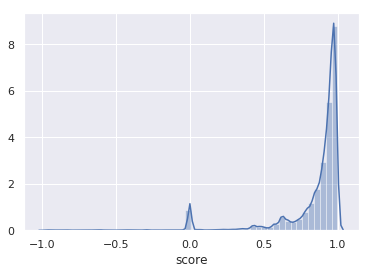

In [38]:
sns.distplot(english_reviews['score'])

In [0]:
# We can now say that everything over 0 is positive (which is a bad assumption...but ok)

english_reviews['positive'] = english_reviews['score'] >= -.5

In [52]:
english_reviews[english_reviews['score'] <= -.5]['comments']

102580    The host did make me feel welcome, but the pla...
289781    As soon as I booked this apartment, I receive ...
302167    I reserved Martha's room a week in advance, an...
205094    Do not expect parking. My mistake was not cons...
237118    Not very clean. Dust and cobwebs everywhere. T...
207144    Joseph is a very nice and friendly person over...
277830    There was no storage space at all - neither in...
78929     Plus for this apartment are good beds, hot wat...
37022     \r\nEnviado: viernes, 4 de diciembre de 2015 1...
329719    We really wanted to leave a better review, but...
115560    The proprietor has a lot more work to do here....
238734    Nice place, but Marco took advantage of us. Up...
140959                                      a very bad host
83226     Despite the great location and safe building, ...
223557    I have stayed for 10 nights at this Studio. Th...
200986    Good location, basic but sufficient apartment....
39856     We sadly had a cancelled fligh



The most simple way to represent text is by using a so called **bag-of-words** approach. Here we simply count up words in phrases to represent and build a table of phrases (rows) and words (columns)

![bow](https://raw.githubusercontent.com/DanAnastasyev/DeepNLP-Course/master/Week%2001/Images/BOW.png)

In python we can do something like that

In [53]:
# Creating a bag of words model

from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

dummy_data = ['it was a great experience',
              'it was a bad experience']

dummy_matrix = vectorizer.fit_transform(dummy_data)


pd.DataFrame(data = dummy_matrix.toarray(), columns = vectorizer.get_feature_names())

,bad,experience,great,it,was
0,0,1,1,1,1
1,1,1,0,1,1


In [0]:
# we will apply this approach to our reviews. But before that we will split up the sample into a training set and a test-set
from sklearn.model_selection import train_test_split

train, test = train_test_split(english_reviews, test_size=0.2)

In [55]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

dummy_labels = [1, 0]

classifier = LogisticRegression()

model = Pipeline([
    ('vectorizer', vectorizer),
    ('classifier', classifier)
])

model.fit(dummy_data, dummy_labels)


pd.DataFrame(data = classifier.coef_, columns = vectorizer.get_feature_names())

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


,bad,experience,great,it,was
0,-0.401058,0.0,0.401058,0.0,0.0


In [56]:
# Let's run a regression on our reviews using the "positive" column as a dependant

model.fit(train['comments'], train['positive'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('vectorizer',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words=None, strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('classifier',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
             

In [57]:
# we can also evaluate the performance

from sklearn.metrics import accuracy_score

def eval_model(model, test_df):
    preds = model.predict(test['comments'])
    print('Test accuracy = {:.2%}'.format(accuracy_score(test['positive'], preds)))
    
eval_model(model, test)

Test accuracy = 99.44%


In [58]:
# Does it really work?

from sklearn.metrics import classification_report

y_pred = model.predict(test['comments'])
y_true = test['positive']

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

       False       0.47      0.26      0.33        27
        True       1.00      1.00      1.00      4973

    accuracy                           0.99      5000
   macro avg       0.73      0.63      0.67      5000
weighted avg       0.99      0.99      0.99      5000



In [59]:
# How about individual predictions?
# We can import the eli5 library that helps us visualising the trained models and results

import eli5
eli5.show_weights(classifier, vec=vectorizer, top=30)

In [60]:
# Let's check some outcomes

print('Positive' if test['positive'].iloc[1] else 'Negative')

eli5.show_prediction(classifier, test['comments'].iloc[1], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Positive


In [61]:
# Let's look at the worst reviews
test[test.positive == 0]

,listing_id,id,date,reviewer_id,reviewer_name,comments,lang,score,positive
362108,32317521,444278196,2019-04-27,220285322,Lizet,"It really is close to the airport, just keep i...",en,-0.6905,False
268129,22320739,318804135,2018-09-04,120091818,Eddie,"You probably don't know, but Jesus never exist...",en,-0.8957,False
135422,14320958,406997251,2019-01-31,28555378,Rob,I was extremely disappointed by the host. I re...,en,-0.9227,False
228331,19999614,364910193,2018-12-31,57454161,Serdar,The place is conveniently located near the Rev...,en,-0.5647,False
269674,22387495,349493513,2018-11-17,8936300,Ronnie,One person could take a shower with about 3 mi...,en,-0.9397,False
228464,20014539,320315442,2018-09-08,19157029,Robin,My husband and I were very excited to stay her...,en,-0.9557,False
7510,796477,362557039,2018-12-26,73038592,Elise,"needs a deep clean, we have stayed in a bunch ...",en,-0.8418,False
349945,29970560,401696158,2019-01-15,4285112,Aziz,"great place great location. but, i froze to de...",en,-0.6530,False
78929,9411939,422644539,2019-03-11,528720,Susan Simone,"Plus for this apartment are good beds, hot wat...",en,-0.8807,False
4613,480752,171779290,2017-07-18,6761119,Harlen,Jeppe's place is central and close to a metro ...,en,-0.6879,False


In [65]:
print('Positive' if test[test.positive == 0]['positive'].iloc[2] else 'Negative')

eli5.show_prediction(classifier, test[test.positive == 0]['comments'].iloc[2], vec=vectorizer, 
                     targets=['positive'], target_names=['negative', 'positive'])

Negative


## Short intro to Word Vectors

![](http://ruder.io/content/images/size/w1000/2017/10/semantic_change.png)

Word embeddings became big around 2013 and are linked to [this paper](https://arxiv.org/abs/1301.3781) with the beautiful title 
*Efficient Estimation of Word Representations in Vector Space* by Tomas Mokolov et al. coming out of Google. This was the foundation of Word2Vec.

The idea behind it is easiest summarized by the following quote: 


> *You shall know a word by the company it keeps (Firth, J. R. 1957:11)*

Let me start with a fascinating example of word embeddings in practice. Below, you can see a figure from the paper: 
*Dynamic Word Embeddings for Evolving Semantic Discovery*. Here (in simple terms) the researchers estimated word vectors for from textual inputs in different time-frames. They picked out some terms and person that obviously changed *their company* over the years. Then they look at the relative position of these terms compared to terms that did not change much (anchors). If you are interested in this kind of research, check out [this blog](https://blog.acolyer.org/2018/02/22/dynamic-word-embeddings-for-evolving-semantic-discovery/) that describes the paper briefly or the [original paper](https://arxiv.org/abs/1703.00607).

![alt text](https://s3-ap-south-1.amazonaws.com/av-blog-media/wp-content/uploads/2017/06/06062705/Word-Vectors.png)

Word embeddings allow us to create term representations that "learn" meaning from semantic and syntactic features. These models take a sequence of sentences as an input and scan for all individual terms that appear in the whole corpus and all their occurrences. Such contextual learning seems to be able to pick up non-trivial conceptual details and it is this class of models that today enable technologies such as chatbots, machine translation and much more.

The early word embedding models were Word2Vec and [GloVe](https://nlp.stanford.edu/projects/glove/).
In December 2017 Facebook presented [fastText](https://fasttext.cc/) (by the way - by 2017 Tomas Mikolov was working for Facebook and is one of the authors of the [paper](https://arxiv.org/abs/1607.04606) that introduces the research behind fastText). This model extends the idea of Word2Vec, enriching these vectors by information from sub-word elements. What does that mean? Words are not only defined by surrounding words but in addition also by the various syllables that make up the word. Why should that be a good idea? Well, now words such as *apple* and *apples* do not only get similar vectors due to them often sharing context but also because they are composed of the same sub-word elements. This comes in particularly handy when we are dealing with language that have a rich morphology such as Turkish or Russian.  This is also great when working with web-text, which is often messy and misspelt.

The current state-of-the-art (April 2018!) is ELMo (Embeddings from Language Models) that further tackles the problem of contextuality and particularly polysemy, i.e. same term means something else in a different context. 

You can read more about the ins and outs of the current state of embedding models [here](https://medium.com/huggingface/universal-word-sentence-embeddings-ce48ddc8fc3a).

Now the good news: You will find pre-trained vectors from all mentioned models online. They will do great in most cases. However, when working with specific tasks: Some obscure languages and/or specific technical jargon (finance talk), it is nice to know how to train such word-vectors.

In this tutorial and on M3 we will not go further than fastText (2017-state-of-the-art should be good enough for us – sorry). You are more than welcome to use other, more sophisticated, embeddings.


In this tutorial we will train three embedding models:

- Word2Vec on text8 - a sample of English Wikipedia
- Word2Vec on the hate speech and toxic comments data
- fastText on the toxic comments data

Once trained, we will store the models

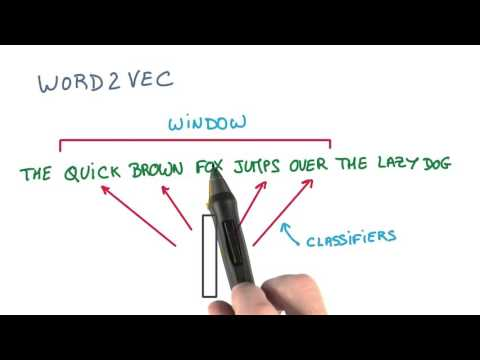

In [89]:
#@title ### One more time
variable_name = ""

from IPython.display import YouTubeVideo
YouTubeVideo('xMwx2A_o5r4',start=0, frameborder="0", width=800, height=500)

In [0]:
# we will train a spanish word-model using gensim and based on all english reviews

from gensim.models import Word2Vec

In [67]:
# Some tools that we need to prepare our data for training

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, sent_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Going back to the full sample
english_reviews = reviews[reviews['lang'] == 'en']

In [0]:
#first we create a list of reviews

texts = list(english_reviews.comments)

In [0]:
# we split the reviews up in sentences

sents = []
for text in texts:
  sents.extend(sent_tokenize(text))

In [71]:
# how many?

len(sents)

772819

In [0]:
# here we create tokenized sentenses - sentences will be now lists of individual words (or tokens)

tokenized_texts = [word_tokenize(text) for text in sents]
tokenized_texts = list(map(lambda x: [y.lower() for y in x], tokenized_texts))

In [73]:
# now we have created a container with word-sequences
tokenized_texts[:5]

[['i', 'loved', 'the', 'experience', '.'],
 ['paige',
  'was',
  'super',
  'knowledgeable',
  'about',
  'craft',
  'beer',
  'and',
  'brought',
  'us',
  'to',
  'some',
  'great',
  'places',
  'in',
  'vancouver',
  '.'],
 ['highly',
  'recommended',
  'for',
  'anyone',
  'wanting',
  'to',
  'learn',
  'more',
  'about',
  'beer',
  'and',
  'try',
  'some',
  'great',
  'local',
  'breweries'],
 ['paige',
  'was',
  'the',
  'perfect',
  'host',
  'and',
  'passed',
  'on',
  'her',
  'wealth',
  'of',
  'knowledge',
  'of',
  'craft',
  'beers',
  'and',
  'the',
  'whereabouts',
  'of',
  'which',
  'we',
  'would',
  'have',
  'not',
  'been',
  'able',
  'to',
  'find',
  'without',
  'her',
  'in-depth',
  'local',
  'knowledge',
  '.'],
 ['we', 'had', 'a', 'great', 'time', '!']]

In [0]:
# We import logging to get informative outputs from Gensim training

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [75]:
# this is how we train the model

model = Word2Vec(tokenized_texts, 
                 size=64,      # embedding vector size
                 min_count=5,  # consider words that occured at least 10 times
                 window=8
                ).wv  # define context as a 5-word window around the target word

2019-08-12 10:22:13,720 : INFO : collecting all words and their counts
2019-08-12 10:22:13,723 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2019-08-12 10:22:13,770 : INFO : PROGRESS: at sentence #10000, processed 156597 words, keeping 6518 word types
2019-08-12 10:22:13,810 : INFO : PROGRESS: at sentence #20000, processed 306416 words, keeping 9394 word types
2019-08-12 10:22:13,850 : INFO : PROGRESS: at sentence #30000, processed 456602 words, keeping 11687 word types
2019-08-12 10:22:13,889 : INFO : PROGRESS: at sentence #40000, processed 607544 words, keeping 13526 word types
2019-08-12 10:22:13,928 : INFO : PROGRESS: at sentence #50000, processed 756366 words, keeping 14995 word types
2019-08-12 10:22:13,969 : INFO : PROGRESS: at sentence #60000, processed 905418 words, keeping 16430 word types
2019-08-12 10:22:14,008 : INFO : PROGRESS: at sentence #70000, processed 1052493 words, keeping 17708 word types
2019-08-12 10:22:14,048 : INFO : PROGRESS: at s

With the trained model, we now can do some interesting exercises:

In [76]:
# e.g. look up synonyms 

model.most_similar('perfect')

2019-08-12 10:25:17,865 : INFO : precomputing L2-norms of word weight vectors
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('ideal', 0.8118923902511597),
 ('fantastic', 0.7782608270645142),
 ('terrific', 0.7630852460861206),
 ('prime', 0.7581384778022766),
 ('great', 0.72962486743927),
 ('superb', 0.7247453927993774),
 ('fabulous', 0.7136520147323608),
 ('wonderful', 0.6941670775413513),
 ('brilliant', 0.6858558654785156),
 ('phenomenal', 0.6433806419372559)]

In [80]:
model.most_similar('dirty')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('dusty', 0.7931612730026245),
 ('broken', 0.7893902063369751),
 ('moldy', 0.7801511287689209),
 ('mold', 0.7728430032730103),
 ('filthy', 0.7682775259017944),
 ('wet', 0.7668278813362122),
 ('holes', 0.7524440288543701),
 ('hairs', 0.7514322996139526),
 ('stained', 0.750318169593811),
 ('dust', 0.7445692420005798)]

In [81]:
# we can print some of the often seen terms
words = sorted(model.vocab.keys(), 
               key=lambda word: model.vocab[word].count,
               reverse=True)[:1000]

print(words[::100])

['.', 'her', 'extremely', 'though', 'far', 'hour', 'natural', 'drink', 'waiting', 'un']


In [0]:
# the model can also return our word-vectors

word_vectors = model.vectors[[model.vocab[word].index for word in words]]

In [0]:
# A function to visualize the vectors (not easy at all)

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()
    
    if isinstance(color, str): 
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: 
        pl.show(fig)
    return fig

In [0]:
# we can project the word vectors into 2dimensinoal space using the new UMAP library
import umap

def get_umap_projection(word_vectors):
    vecs = umap.UMAP(n_neighbors=15, metric='cosine').fit_transform(word_vectors)
    return vecs

In [85]:
word_umap = get_umap_projection(word_vectors[:1000])
draw_vectors(word_umap[:, 0], word_umap[:, 1], color='blue', token=words)

Figure(id='1002', ...)

## Case 3: Predicting categories with a self-trained model

In this case we will use work from Upwork.com (from a recent research paper) to predict task-categories.
Upwork https://www.upwork.com is a platform that connects freelancers with short term employers online. The dataset contains text, describing the task, as well as a category task. Unfortunately, not all task descriptions had these category labels. This is where we will use NLP + ML to create the misssing labels. 

Recent paper with Mareike Seifried and Tobias Kretschmer
https://conference.druid.dk/acc_papers/48ox0g0vwmp0vvx8gj7lzwhbimflf0.pdf

In [0]:
#read in the data
data = pd.read_csv('upwork_aom_300k.csv')

In [91]:
#let's check it
data.head()

,Unnamed: 0,as_opening_title,main_category,sub_category
0,968913,Mailchimp Marketing Assistant,NaN,NaN
1,1855958,Manually submit 2000 names to an online form,Admin Support,Data Entry
2,109271,Design,NaN,NaN
3,1349850,Cool and Fun Graphic Designer/Illustrator need...,Design & Creative,Graphic Design
4,729567,Html/css/js,NaN,NaN


In [92]:
#some descriptives

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 4 columns):
Unnamed: 0          300000 non-null int64
as_opening_title    299998 non-null object
main_category       87967 non-null object
sub_category        87967 non-null object
dtypes: int64(1), object(3)
memory usage: 9.2+ MB


In [0]:
# selecting the empty ones

data_subset_empty = data[data['main_category'].isnull()]

In [0]:
# selecting the complete ones

data_full = data[~data['main_category'].isnull()]

In [95]:
#Some descriptives of the complete table

data_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87967 entries, 1 to 299998
Data columns (total 4 columns):
Unnamed: 0          87967 non-null int64
as_opening_title    87967 non-null object
main_category       87967 non-null object
sub_category        87967 non-null object
dtypes: int64(1), object(3)
memory usage: 3.4+ MB


In [96]:
# Print out the different categories of tasks

for i in data_full['main_category'].unique():
    print(i)

Admin Support
Design & Creative
Sales & Marketing
Writing
Web, Mobile & Software Dev
Accounting & Consulting
Data Science & Analytics
IT & Networking
Translation
Engineering & Architecture
Customer Service
Legal
Web & Mobile Development


Now we need to construct our dependant and indepandant variables
The independant will be the vector representations of the texts
The dependant variable will be a the category of jobs

In [0]:
# import encoders for the dependant variable

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

In [98]:
# encode the dependant into dummy variables

encoder = LabelEncoder()
onehot = OneHotEncoder()

encoded = encoder.fit_transform(data_full['main_category']) #categorical index
y = onehot.fit_transform(encoded.reshape(-1,1)) # dummy matrix

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


We will be using spacy: https://spacy.io
It is a moden and fast NLP library that allows to do NLP tasks without engaging too much with linguistics and low-level tasks
you can download more and other models (also spanish) here https://spacy.io/usage/models

In [0]:
# download and install a large spacy model. For simple tasks, the small model
# spacy.load('en') is OK and already installed
!python -m spacy download en_core_web_lg

In [0]:
# load up a pretrained (there are also spanish models available)

import en_core_web_lg
nlp = en_core_web_lg.load()

In the next step we will use Spacy to work with the language data


In [0]:
# Vectorizing the text-data
vector_list = []

for doc in nlp.pipe(data_full['as_opening_title'], n_threads=4, batch_size=10000):
    vector_list.append(doc.vector)

In [0]:
# Assamble the list of vectors into a matrix
X = np.vstack(vector_list)

Having created the variables, we can now split the dataset and train some models

In [0]:
# splitting the data

X_train, X_test, y_train, y_test = train_test_split(X, encoded, test_size=0.2)

In [114]:
# Training a logistic regression

classifier = LogisticRegression(multi_class='multinomial',solver='lbfgs')
classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [115]:
# How are we doing?

from sklearn.metrics import classification_report

y_pred = classifier.predict(X_test)

classes_list = y_test.tolist() + y_pred.tolist()

labels = sorted(set(classes_list))
targets = encoder.inverse_transform(labels)

print(classification_report(y_test, y_pred, target_names = targets))

                            precision    recall  f1-score   support

   Accounting & Consulting       0.61      0.42      0.50       266
             Admin Support       0.65      0.68      0.67      2065
          Customer Service       0.59      0.36      0.45       113
  Data Science & Analytics       0.49      0.17      0.25       253
         Design & Creative       0.82      0.85      0.84      3774
Engineering & Architecture       0.68      0.46      0.55       337
           IT & Networking       0.65      0.40      0.50       382
                     Legal       0.65      0.41      0.50        49
         Sales & Marketing       0.67      0.59      0.62      1282
               Translation       0.87      0.84      0.85       826
  Web & Mobile Development       0.00      0.00      0.00         2
Web, Mobile & Software Dev       0.81      0.89      0.85      5424
                   Writing       0.81      0.82      0.81      2821

                  accuracy                    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Finally, we will be training an artificial neural network
We will be using Keras for setting it up and training.

In [116]:
# Importing the keras library for deep learning

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

Using TensorFlow backend.


![alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/4/46/Colored_neural_network.svg/600px-Colored_neural_network.svg.png)

In [0]:
classifier = Sequential() 

#### RED ####
classifier.add(Dense(units = 256, activation='relu', input_dim = 300))

#### BLUE ####
classifier.add(Dropout(rate = 0.3))
classifier.add(Dense(units = 512, activation='relu'))
classifier.add(Dropout(rate = 0.1))
classifier.add(Dense(units = 64,  activation='relu'))


#### GREEN ####
classifier.add(Dense(units = 13, activation='softmax'))


#### COMPILE ####
classifier.compile(optimizer="adam", loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [118]:
classifier.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               77056     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_4 (Dense)              (None, 13)                845       
Total params: 242,317
Trainable params: 242,317
Non-trainable params: 0
_________________________________________________________________


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [122]:
history = classifier.fit(X_train, y_train, batch_size= 500, epochs= 10, validation_data=(X_test, y_test))

W0812 12:38:40.774601 139647347070848 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 70373 samples, validate on 17594 samples
Epoch 1/10
70373/70373 [==============================] - 5s 74us/step - loss: 1.0233 - acc: 0.6911 - val_loss: 0.7392 - val_acc: 0.7770
Epoch 2/10
70373/70373 [==============================] - 4s 61us/step - loss: 0.7462 - acc: 0.7725 - val_loss: 0.6884 - val_acc: 0.7888
Epoch 3/10
70373/70373 [==============================] - 4s 60us/step - loss: 0.7010 - acc: 0.7861 - val_loss: 0.6652 - val_acc: 0.7953
Epoch 4/10
70373/70373 [==============================] - 4s 61us/step - loss: 0.6717 - acc: 0.7949 - val_loss: 0.6539 - val_acc: 0.8006
Epoch 5/10
70373/70373 [==============================] - 4s 58us/step - loss: 0.6528 - acc: 0.8006 - val_loss: 0.6479 - val_acc: 0.8009
Epoch 6/10
70373/70373 [==============================] - 4s 56us/step - loss: 0.6364 - acc: 0.8042 - val_loss: 0.6372 - val_acc: 0.8031
Epoch 7/10
70373/70373 [==============================] - 4s 56us/step - loss: 0.6209 - acc: 0.8081 - val_loss: 0.6316 - val_acc

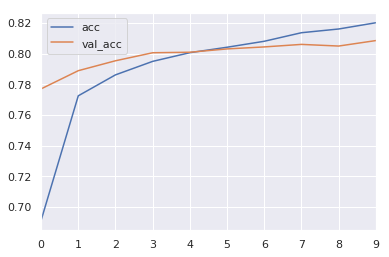

In [124]:
pd.DataFrame(history.history)[['acc','val_acc']].plot()

In [125]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis=1)
labels = sorted(set([x[0] for x in y_true.tolist()]))
targets = encoder.inverse_transform(labels)

y_pred = classifier.predict_classes(X_test)

print(classification_report(y_true, y_pred, target_names=targets))

                            precision    recall  f1-score   support

   Accounting & Consulting       0.66      0.57      0.61       307
             Admin Support       0.68      0.74      0.71      2082
          Customer Service       0.69      0.45      0.54       128
  Data Science & Analytics       0.47      0.21      0.29       259
         Design & Creative       0.86      0.87      0.86      3805
Engineering & Architecture       0.68      0.72      0.70       335
           IT & Networking       0.67      0.38      0.48       356
                     Legal       0.63      0.56      0.59        48
         Sales & Marketing       0.72      0.62      0.66      1243
               Translation       0.84      0.92      0.88       853
  Web & Mobile Development       0.00      0.00      0.00         1
Web, Mobile & Software Dev       0.84      0.90      0.87      5380
                   Writing       0.88      0.82      0.85      2797

                  accuracy                    

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [0]:
new_data = data_subset_empty.sample(1000)['as_opening_title']

In [0]:
new_data.index = range(len(new_data))

In [0]:
new_X = []

for doc in nlp.pipe(new_data, n_threads=4, batch_size=10000):
    new_X.append(doc.vector)

new_X = np.vstack(new_X)

In [0]:
predictions = classifier.predict_classes(new_X)

In [0]:
result = pd.concat([new_data, pd.Series(predictions.tolist())], axis=1)

In [0]:
result['category'] = encoder.inverse_transform(result[0])

In [132]:
result['category'].unique()

array(['Admin Support', 'Web, Mobile & Software Dev', 'Writing',
       'Design & Creative', 'Legal', 'Sales & Marketing',
       'IT & Networking', 'Translation', 'Engineering & Architecture',
       'Accounting & Consulting', 'Data Science & Analytics',
       'Customer Service'], dtype=object)

In [133]:
result[result.category == 'Writing']

,as_opening_title,0,category
2,"USA Book reviewers needed. Simple, fast and ea...",12,Writing
11,SEO friendly Articles,12,Writing
15,Ongoing Content Writers,12,Writing
19,I Need a Full Time Writer for Various Blogs (S...,12,Writing
66,Gaming Blogger Ongoing Work - Farrukh,12,Writing
70,need help with basic Microeconomics theories,12,Writing
73,Writer needed for 10 articles,12,Writing
79,Native English Speaking Teacher,12,Writing
80,2 sets of 25 pages each - FastMed and Broadban...,12,Writing
82,Screenplay Review,12,Writing
